# Project 01 - Data 620

Trishita Nath

## Project Overview

For your first project, you are asked to
1.   Identify and load a network dataset that has some categorical information available for each node.
2.   For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
3.   Compare your centrality measures across your categorical groups.

For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio http://researchnews.osu.edu/archive/chains.htm, you might want to determine if there are any differences in your calculated centrality measures between the two sexes. You might use a t-test or another statistical measure to support your findings.


## Network Data

I will select network data from [OpenFlights](https://openflights.org/data.html)

Openflights is *a tool that lets you map your flights around the world, search and filter them in all sorts of interesting ways, calculate statistics automatically, and share the resulting maps with friends and the world. You can also check airport route maps for nearly every airport in the world and find out what airlines fly where.*

I will use the *Routes* and *Airports* datasets to build the network. I already described this data in Assignment 4.

OpenFlights datasets include:
*   [Airports](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat)
*   [Airports-extended](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports-extended.dat)
*   [Airlines](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat)
*   [Routes](https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat)
*   [Planes](https://raw.githubusercontent.com/jpatokal/openflights/master/data/planes.dat)
*   [Countries](https://raw.githubusercontent.com/jpatokal/openflights/master/data/countries.dat)




I will take the nodes from the *Source Airport* and *Destination Airport* variables in the **Routes dataset**.  A node is represented by each record with a source and destination airport. The Stops variable could be used as an optional edge weight.

## Categorical Variable

In my case the categorical variable is going to be *N_S_Hemisphere* from the Latitude variable in the Airports dataset. A node with a Negative latitude will be denoted by **S** for "South", and a positive latitude will be denoted by **N** for "North".

## Data Loading

In [26]:
# Import packages
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# Routes dataframe
df_routes_all = pd.read_csv("routes.dat", 
                       header=None, sep=",", 
                       usecols=[2, 4, 7], 
                       names=['Source Airport','Destination Airport', 'Stops'])
df_routes_all.head()

,Source Airport,Destination Airport,Stops
0,AER,KZN,0
1,ASF,KZN,0
2,ASF,MRV,0
3,CEK,KZN,0
4,CEK,OVB,0


In [28]:
# Airports dataframe
df_airports_all = pd.read_csv("airports.dat", 
                       header=None, sep=",", 
                       usecols=[1, 2, 3, 4, 6, 7], 
                       names=['Airport Name','City','Country','IATA', 'Latitude', 'Longitude'])
df_airports_all.head()

,Airport Name,City,Country,IATA,Latitude,Longitude
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001


Due to the enormous data I will focus my analysis on the Eastern Hemisphere only by filtering out all airports in the Western Hemisphere based on Longitude.

In [29]:
df_airports_all = df_airports_all[df_airports_all.Longitude > 0]
df_airports_all.head()

,Airport Name,City,Country,IATA,Latitude,Longitude
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001


## Data Wrangling

### Creating the Categorical Variable

I will create the Hemisphere variable by coding each airport in the Airports dataframe with 'N' or 'S'

In [30]:
df_airports_all['Hemisphere'] = np.where(df_airports_all['Latitude'] >= 0, 'N', 'S')
df_airports_all.head()

,Airport Name,City,Country,IATA,Latitude,Longitude,Hemisphere
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998,S
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001,S
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005,S
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977,S
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001,S


### Creating the Node List



Check if all the same airports are listed in both the source and destination airports of the routes data

In [31]:
set(df_routes_all['Source Airport']) == set(df_routes_all['Destination Airport'])
len(df_routes_all['Source Airport'].unique())
len(df_routes_all['Destination Airport'].unique())

3418

Since they are not the same, I will take the union of the two sets to make the list of nodes.

In [32]:
df_airport_nodes = set(df_routes_all['Source Airport']) | set(df_routes_all['Destination Airport'])
len(df_airport_nodes)

3425

Convert the nodes list a pandas dataframe so it can be merged with the airports data to get the Hemisphere categorical variable. This will also filter out the Airports in the Western Hemisphere.

In [33]:
df_airport_nodes = pd.DataFrame(df_airport_nodes, columns = ['IATA'])
df_airport_nodes = pd.merge(df_airport_nodes, df_airports_all, on='IATA', how='inner')
df_airport_nodes.head()
# Number of nodes
len(df_airport_nodes)

1790

### Creating Edge List

The edge list is the df_routes_all dataframe created from the routes data. Filter out any edges that contain the nodes that we don't have Hemisphere data for or that are in the Western Hemisphere. This is done by merging the routes data with the df_airport_nodes data.


In [34]:
len(df_routes_all)
df_routes_merged1 = pd.merge(df_routes_all,df_airport_nodes[['IATA']],left_on='Source Airport',right_on='IATA',how='inner')
df_routes_merged2 = pd.merge(df_routes_merged1,df_airport_nodes[['IATA']],left_on='Destination Airport',right_on='IATA',how='inner')
routes = df_routes_merged2.loc[:, 'Source Airport':'Stops']
routes.head()
len(routes)

36243

36243 are the remaining routes/edges for the graph.

### Creating a Network Graph

In [35]:
g = nx.from_pandas_edgelist(routes, 'Source Airport', 'Destination Airport', True, nx.DiGraph())
nx.set_node_attributes(g, df_airport_nodes.set_index('IATA').to_dict('index'))

#### 1. Degree of Centrality

In [36]:
deg = nx.degree(g)
df_deg = pd.DataFrame(deg, columns = ['IATA', 'Deg_Centrality'])
df_deg = pd.merge(df_deg, df_airports_all, on='IATA', how='inner')
df_sorted_deg = df_deg.sort_values('Deg_Centrality', ascending = False)
df_sorted_deg.head()

,IATA,Deg_Centrality,Airport Name,City,Country,Latitude,Longitude,Hemisphere
17,IST,408,Istanbul Airport,Istanbul,Turkey,41.275278,28.751944,N
92,PEK,378,Beijing Capital International Airport,Beijing,China,40.080101,116.584999,N
4,DME,352,Domodedovo International Airport,Moscow,Russia,55.408798,37.906300,N
30,FRA,332,Frankfurt am Main Airport,Frankfurt,Germany,50.033333,8.570556,N
27,DXB,320,Dubai International Airport,Dubai,United Arab Emirates,25.252800,55.364399,N


In [37]:
df_sorted_deg.tail()

,IATA,Deg_Centrality,Airport Name,City,Country,Latitude,Longitude,Hemisphere
1436,MSW,1,Massawa International Airport,Massawa,Eritrea,15.670000,39.370098,N
1748,FMI,1,Kalemie Airport,Kalemie,Congo (Kinshasa),-5.875560,29.250000,S
1750,DLZ,1,Dalanzadgad Airport,Dalanzadgad,Mongolia,43.591702,104.430000,N
779,VDA,1,Ovda International Airport,Ovda,Israel,29.940300,34.935799,N
1380,LJA,1,Lodja Airport,Lodja,Congo (Kinshasa),-3.417000,23.450001,S


The highest degree centrality was for northern airports only, while the lowest degree centrality values are also for Northern airports only as well.

Distribution of Degree Centrality in Northern vs. Southern Hemisphere

---


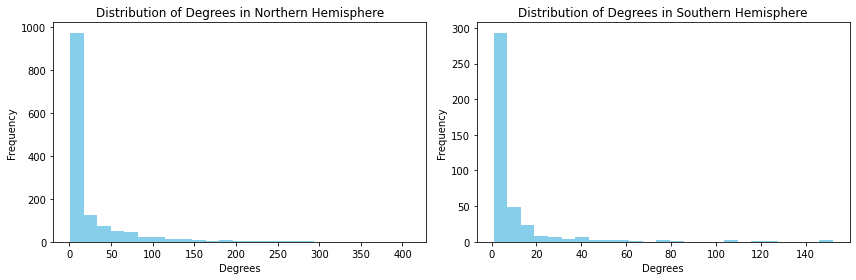

In [38]:
degN = df_deg[df_deg.Hemisphere=='N']
degS = df_deg[df_deg.Hemisphere=='S']

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(degN['Deg_Centrality'], 25, color = "skyblue")
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees in Northern Hemisphere')

plt.subplot(1, 2, 2)
plt.hist(degS['Deg_Centrality'], 25, color = "skyblue")
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees in Southern Hemisphere')

plt.tight_layout()
plt.show()

#### 2. Calculating Eigenvector Centrality

In [39]:
eig = nx.eigenvector_centrality(g)
df_eig = pd.DataFrame.from_dict(eig, orient='index').reset_index()
df_eig.columns = ['IATA', 'Eig_Centrality']
df_eig = pd.merge(df_eig, df_airports_all, on='IATA', how='inner')
sorted_eig = df_eig.sort_values('Eig_Centrality', ascending = False)

sorted_eig.head()

,IATA,Eig_Centrality,Airport Name,City,Country,Latitude,Longitude,Hemisphere
30,FRA,0.180065,Frankfurt am Main Airport,Frankfurt,Germany,50.033333,8.570556,N
17,IST,0.168890,Istanbul Airport,Istanbul,Turkey,41.275278,28.751944,N
65,AMS,0.163915,Amsterdam Airport Schiphol,Amsterdam,Netherlands,52.308601,4.763890,N
68,CDG,0.160165,Charles de Gaulle International Airport,Paris,France,49.012798,2.550000,N
44,MUC,0.160023,Munich Airport,Munich,Germany,48.353802,11.786100,N


In [40]:
sorted_eig.tail()

,IATA,Eig_Centrality,Airport Name,City,Country,Latitude,Longitude,Hemisphere
1761,MEB,1.439275e-47,Melbourne Essendon Airport,Melbourne,Australia,-37.7281,144.901993,S
1772,PTJ,5.140268e-49,Portland Airport,Portland,Australia,-38.3181,141.470993,S
779,VDA,5.140268e-49,Ovda International Airport,Ovda,Israel,29.9403,34.935799,N
1380,LJA,5.140268e-49,Lodja Airport,Lodja,Congo (Kinshasa),-3.4170,23.450001,S
1436,MSW,5.140268e-49,Massawa International Airport,Massawa,Eritrea,15.6700,39.370098,N


Similarly, the top values are for Northern airports only, and the lowest values are for almost all Northern airports as well.

Distribution of Degree Centrality in Northern vs. Southern Hemisphere

---


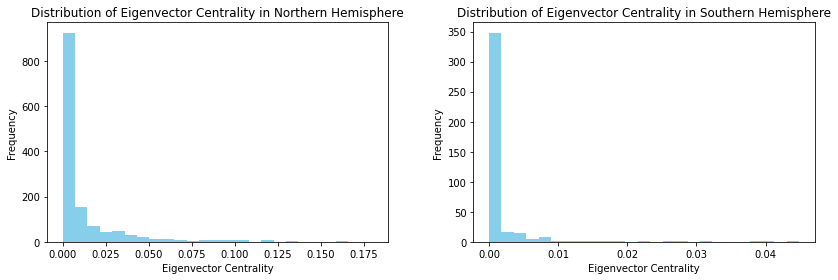

In [41]:
eigN = df_eig[df_eig.Hemisphere=='N']
eigS = df_eig[df_eig.Hemisphere=='S']

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(eigN['Eig_Centrality'], 25, color = "skyblue")
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Eigenvector Centrality in Northern Hemisphere')

plt.subplot(1, 2, 2)
plt.hist(eigS['Eig_Centrality'], 25, color = "skyblue")
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Eigenvector Centrality in Southern Hemisphere')

plt.tight_layout()
plt.show()

### Visualization of Air Routes Network

#### Visualization for the Southern Hemisphere

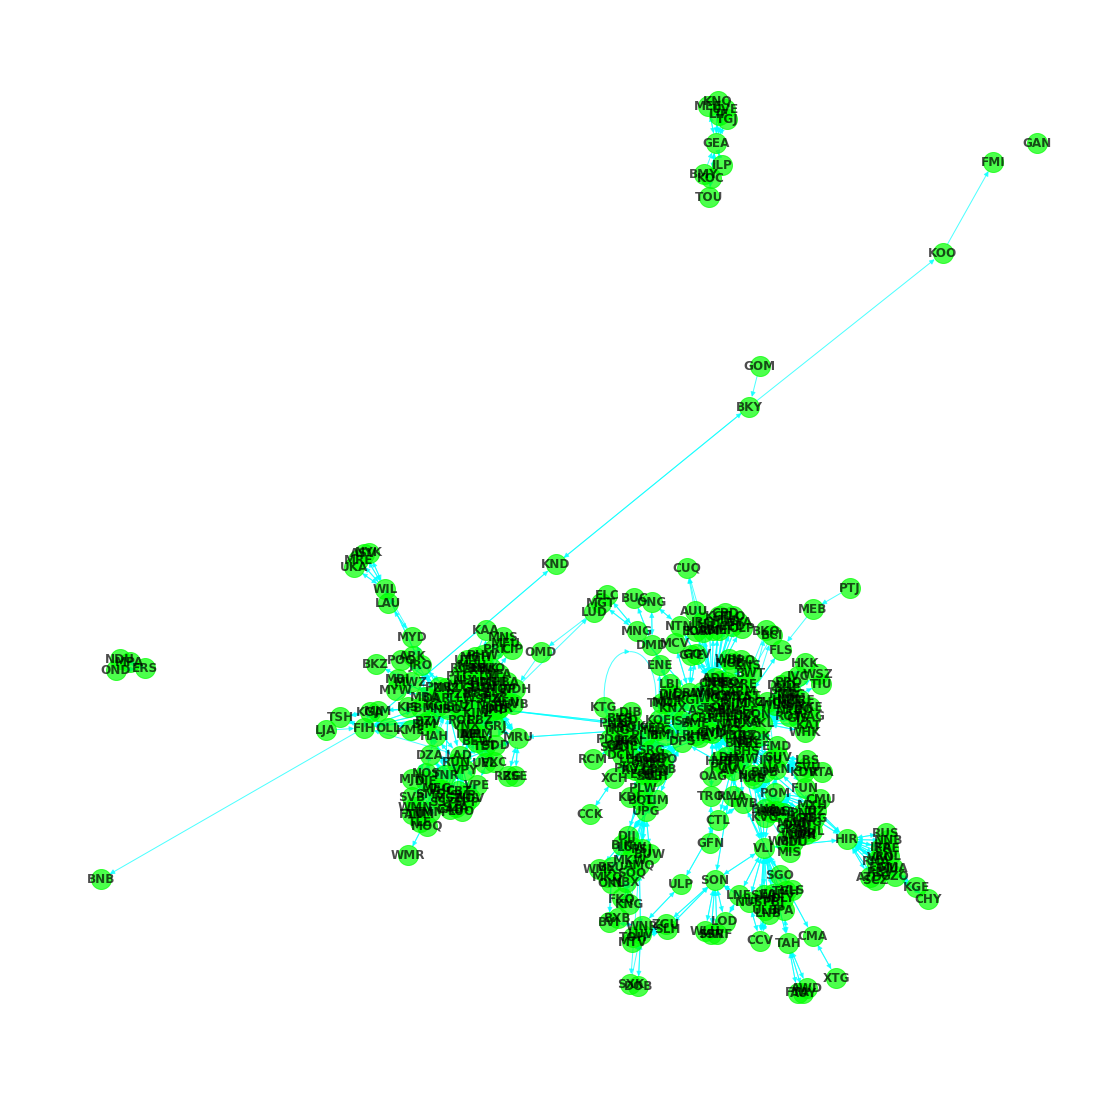

In [42]:
plt.rcParams["figure.figsize"] = (15,15)

I = g.subgraph(list(degS['IATA']))

# Draw the Graph
nx.draw(I, with_labels=True, node_size=400, node_color='lime', font_weight='bold', 
        edge_color="cyan", alpha=0.7)

#### Visualization for the Nothern Hemisphere

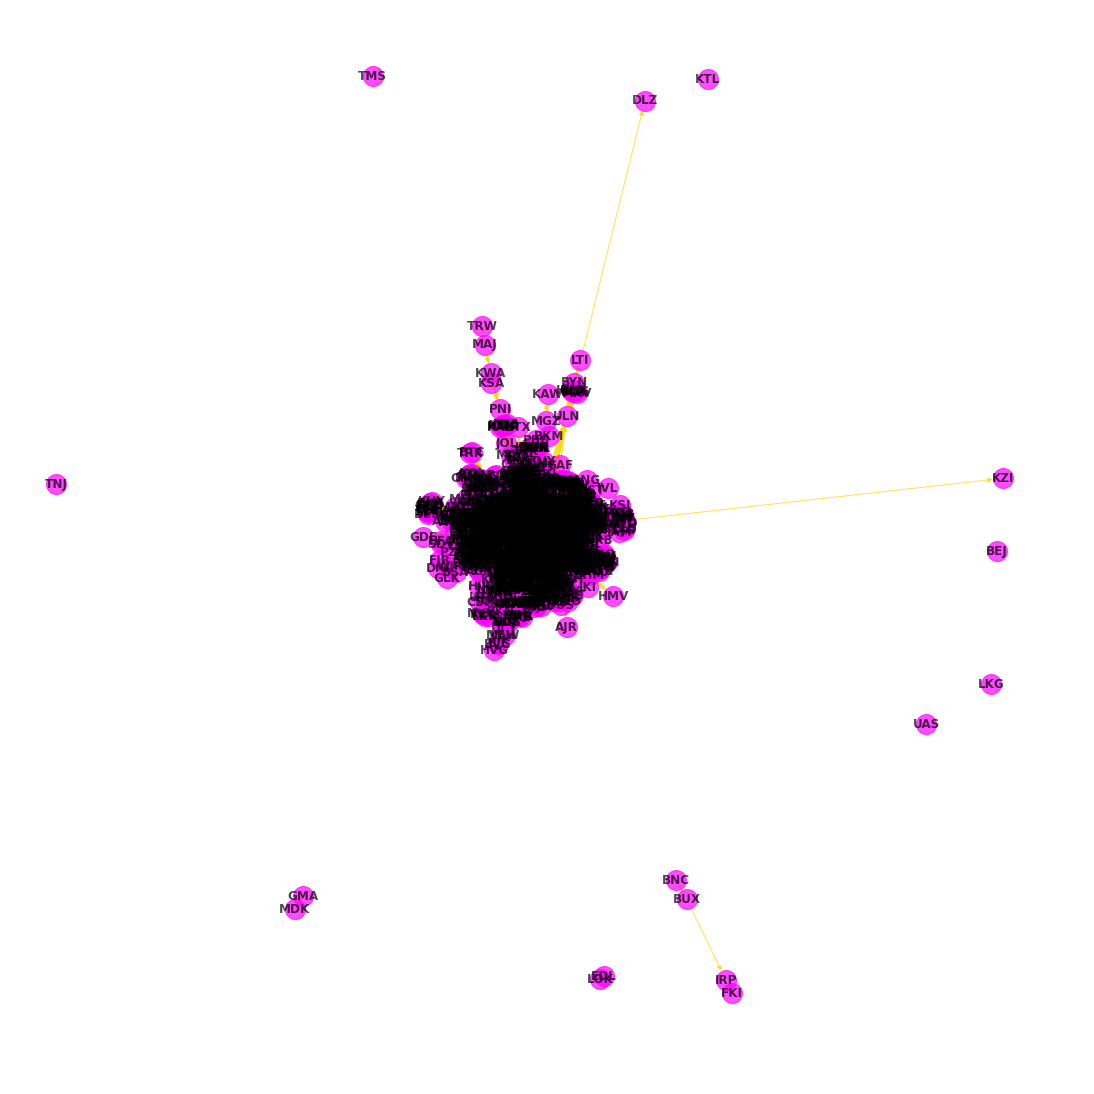

In [43]:
plt.rcParams["figure.figsize"] = (15,15)

H = g.subgraph(list(degN['IATA']))

# Graph
nx.draw(H, with_labels=True, node_size=400, node_color='magenta', font_weight='bold', 
        edge_color="gold", alpha=0.7)

#### Combined Hemispheres

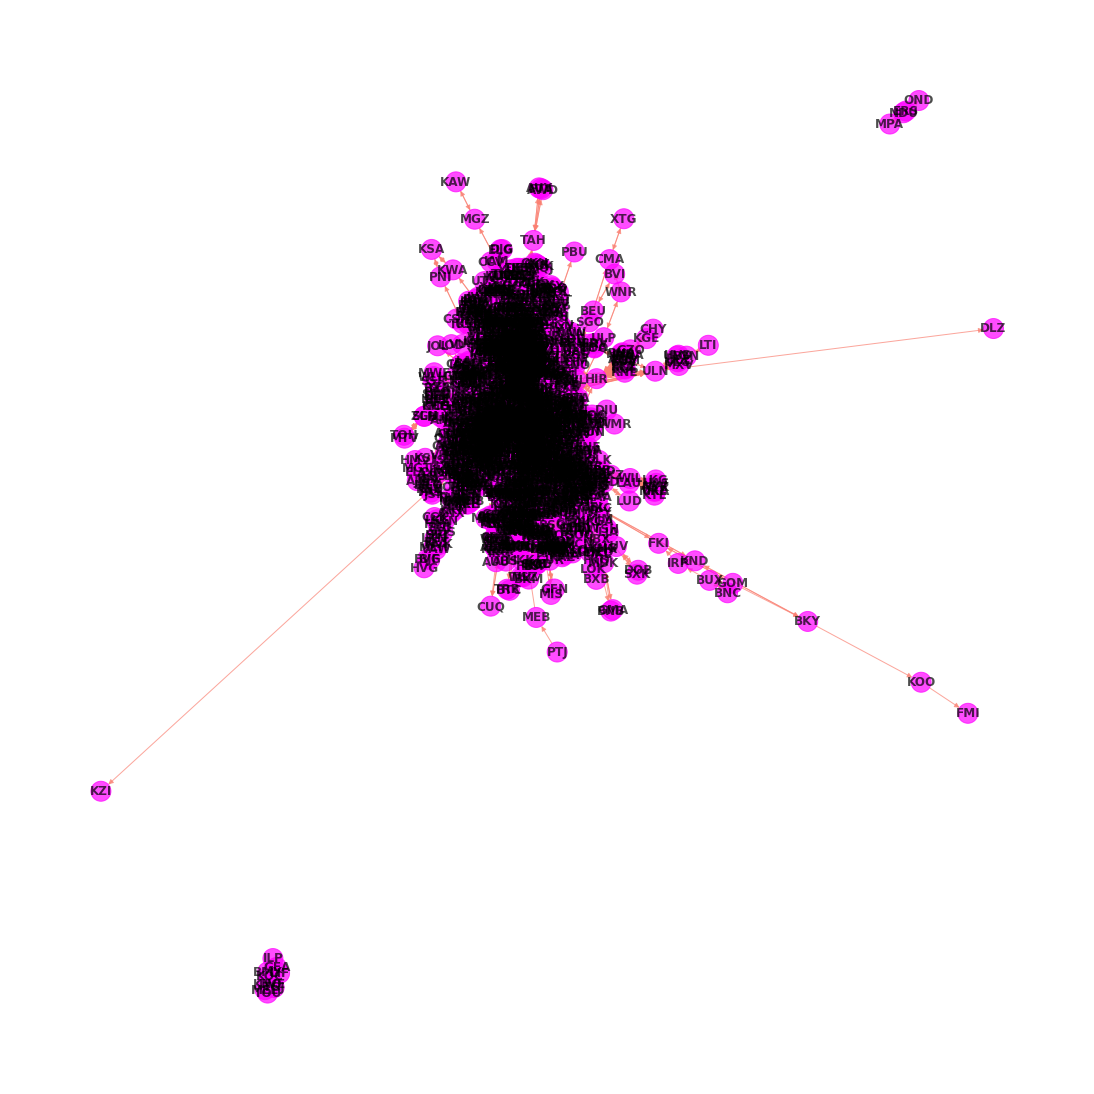

In [44]:
plt.rcParams["figure.figsize"] = (15,15)

# Empty list for node colors
colors = []

# Color each node based on their Hemisphere
for node, data in g.nodes(data=True):
    if data['Hemisphere'] == 'N':
        colors.append('magenta')         
    else:
        colors.append('magenta')

# Graph
nx.draw(g, with_labels=True, node_size=400, node_color=colors, font_weight='bold', 
        edge_color="salmon", alpha=0.7) 